# 1D Wave-equation / linearized shallow-water equation on a periodic domain

The one-dimensional shallow-water equations can be linearized and simplified to the 1D wave-equation:

$\partial h/\partial t + D \partial u / \partial x = 0$

$\partial u/\partial t + g \partial h / \partial x = 0$

where $h$ denotes the water-height above the reference, $u$ the velocity, $D$ the depth below the reference and $t,x$ time and space.

In [1]:
# goto folder of this notebook (If you move this notebook then also copy the Project.toml file and run instantiate to install the packages)
cd(@__DIR__)
# load the environment
using Pkg 
Pkg.activate(".")  # activate the environment for this notebook
# load the packages
using OrdinaryDiffEq
using ComponentArrays
using Plots
using JLD2


  Activating project at `~/dellete/src/julia_ml_tests.jl.git/model_1d`


In [3]:
# Load model definition
include("../model_1d/model_1d_wave_periodic.jl")

Wave1DPeriodic_cpu

In [4]:
# setting up the problem
# parameters
nx=200     # number of spatial points
L=10000.0  # length of the domain
dx=L/nx    # spatial step
D=10.0     # depth of the water
g=10.0     # acceleration due to gravity

# initial state
f=Wave1DPeriodic_cpu(g,D,L,dx,nx)
x0=initial_state_bump(f,1.0,0.05,0.5)

# time span
t_start=0.0
t_end=1000.0

# spatial grid (for plotting)
x_h = 0.0:f.dx:(f.L-f.dx/2)
x_u = (f.dx/2):f.dx:f.L
x=ComponentVector(h=x_h,u=x_u)

ComponentVector{Float64}(h = [0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0  …  9500.0, 9550.0, 9600.0, 9650.0, 9700.0, 9750.0, 9800.0, 9850.0, 9900.0, 9950.0], u = [25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0  …  9525.0, 9575.0, 9625.0, 9675.0, 9725.0, 9775.0, 9825.0, 9875.0, 9925.0, 9975.0])

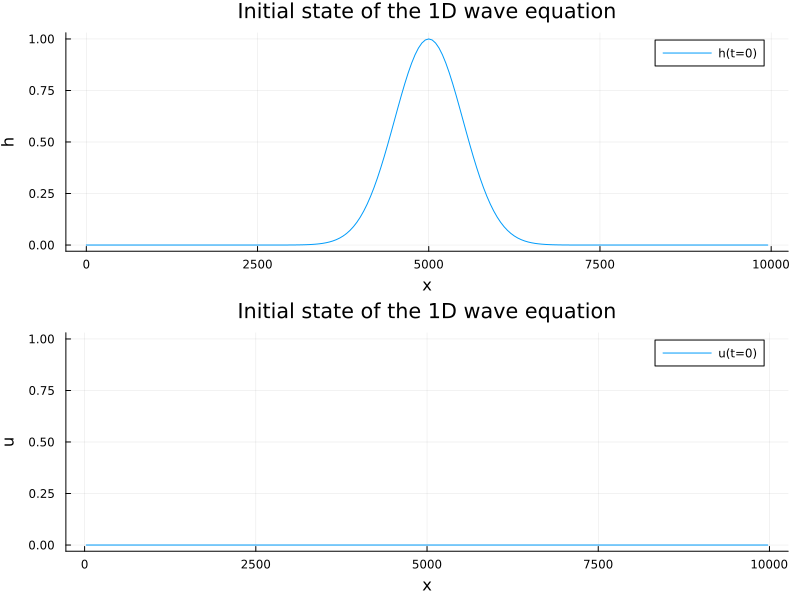

In [5]:
# plot the initial state
p1=plot(x_h, x0.h, label="h(t=0)", xlabel="x", ylabel="h")
p2=plot(x_u, x0.u, label="u(t=0)", xlabel="x", ylabel="u")
plot(p1, p2, layout=(2,1), size=(800,600), title="Initial state of the 1D wave equation")

In [6]:
prob = ODEProblem(f, x0, (t_start, t_end))
@time sol = solve(prob, Tsit5(),saveat=10.0) # with timing, but ouput only at t=10.0
sol = solve(prob, Tsit5()) # store output, no timing

nothing

  1.453932 seconds (8.03 M allocations: 436.640 MiB, 6.81% gc time, 99.89% compilation time)


┌ Info: Saved animation to /home/verlaan/dellete/src/julia_ml_tests.jl.git/model_1d/wave1d_periodic.gif
└ @ Plots /home/verlaan/.julia/packages/Plots/uiCPf/src/animation.jl:156


  9.351565 seconds (7.27 M allocations: 353.201 MiB, 0.39% gc time, 4.33% compilation time: 9% of which was recompilation)


Plots.AnimatedGif("/home/verlaan/dellete/src/julia_ml_tests.jl.git/model_1d/wave1d_periodic.gif")
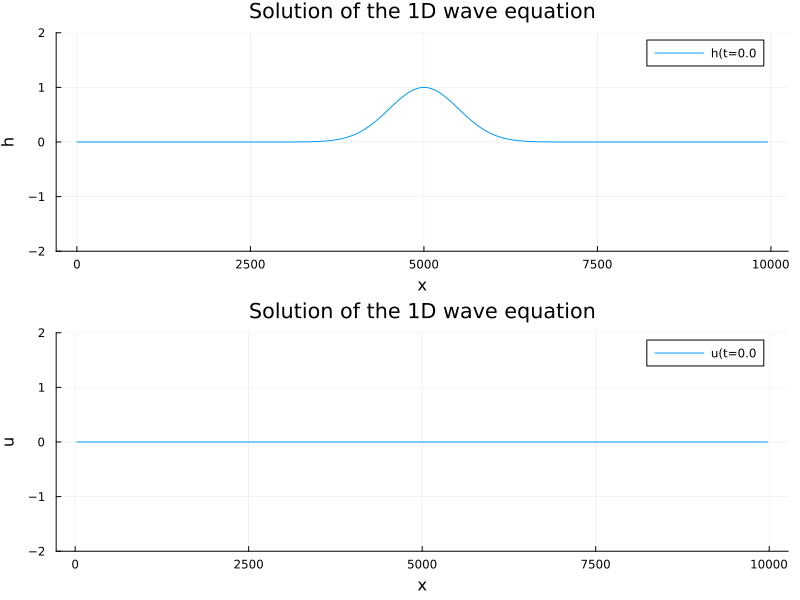

In [7]:
# create a movie of the solution
@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(sol.t)
        p1 = plot(x_h, sol[i].h, label="h(t=$(round(sol.t[i],digits=1))", xlabel="x", ylabel="h", ylim=(-2, 2))
        p2 = plot(x_u, sol[i].u, label="u(t=$(round(sol.t[i],digits=1))", xlabel="x", ylabel="u", ylim=(-2, 2))
        plot(p1, p2, layout=(2,1), size=(800,600), title="Solution of the 1D wave equation")
    end
    gif(anim, "wave1d_periodic.gif", fps=30)
end


In [8]:
# save the solution to a JLD2 file
cfl_out=1.0 # CFL number for output
dt_out=cfl_out*f.dx/(sqrt(f.D*f.g)) # time step for output, based on CFL condition
times=collect(0.0:dt_out:t_end) # output times
solution=[]
for t in times
    push!(solution, sol(t))
end
# save the solution to a JLD2 file
save("wave1d_periodic.jld2", 
    "solution", solution,
    "times", times,
    "params", (g=f.g, D=f.D, L=f.L, dx=f.dx, nx=f.nx),
    "grid", x,
    "cfl_out", cfl_out,
    "dt_out", dt_out,
    "description", "Solution of the 1D wave equation with periodic boundary conditions, using a Gaussian bump as initial condition.")


In [ ]:
# load the solution from the JLD2 file for testing
ff=load("wave1d_periodic.jld2")

@show ff["solution"][1].h[1:20:end] # show some values of the initial height field